# Text-based Emotion Recognition

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import text_hammer as th
import numpy as np

## Get data

In [2]:
df_train = pd.read_csv('archive/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('archive/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val = pd.read_csv('archive/val.txt',header=None,sep=';', names=['Input','Sentiment'], encoding='utf-8')
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Vizualisation of data

/Users/lucas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


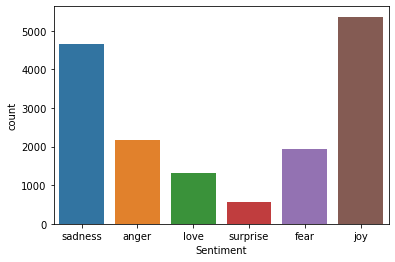

In [3]:
sns.countplot(df_train.Sentiment)
plt.show()

## Preprocessing

## Clean data

In [4]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].apply(lambda x:str(x).lower())
    df[column] = df[column].apply(lambda x: th.cont_exp(x))
    df[column] = df[column].apply(lambda x: th.remove_emails(x))
    df[column] = df[column].apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].apply(lambda x: th.make_base(x))
    return(df)

In [5]:
df_cleaned_train = text_preprocessing(df_train, 'Input')

In [6]:
df_cleaned_train['Sentiment'] = df_cleaned_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment'] = df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment'] = df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

## Class the output

In [7]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

## Tokenization

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input']) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

## Word embedding

In [11]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

In [12]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_word_matrix = []
gensim_weight_matrix.shape

(10000, 100)

In [13]:
for word, index in tokenizer.word_index.items():
    if index < num_words :
        gensim_word_matrix.append(word)
        if word in glove_gensim.key_to_index:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [14]:
#Compress the word vectors into 2D space
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(gensim_weight_matrix)
word_vectors_matrix_2d.shape

(10000, 2)

In [17]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[gensim_word_matrix.index(word)])
            for word in gensim_word_matrix
        ]
    ],
    columns=["word", "x", "y"]
)

In [19]:
points.head(10)

,word,x,y
0,i,21.541929,9.513305
1,feel,-36.259872,-11.290086
2,and,-32.744148,-7.214372
3,to,-55.122707,-7.947130
4,the,-45.726959,-8.646594
5,a,-54.384018,-6.667532
6,that,-53.653149,-8.681715
7,of,-51.111652,-8.169118
8,my,-54.664215,-6.573995
9,have,-36.803135,-12.740060


## Vizualisation of embedded words

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

<AxesSubplot:xlabel='x', ylabel='y'>

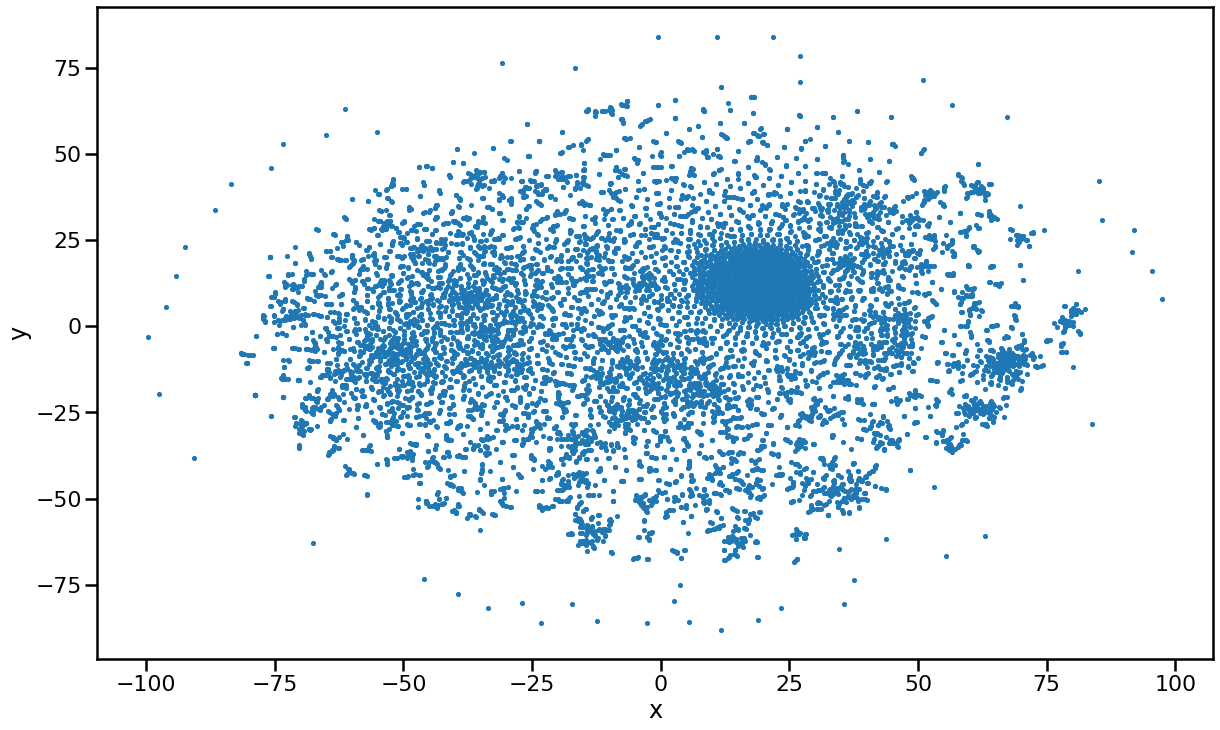

In [21]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [22]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

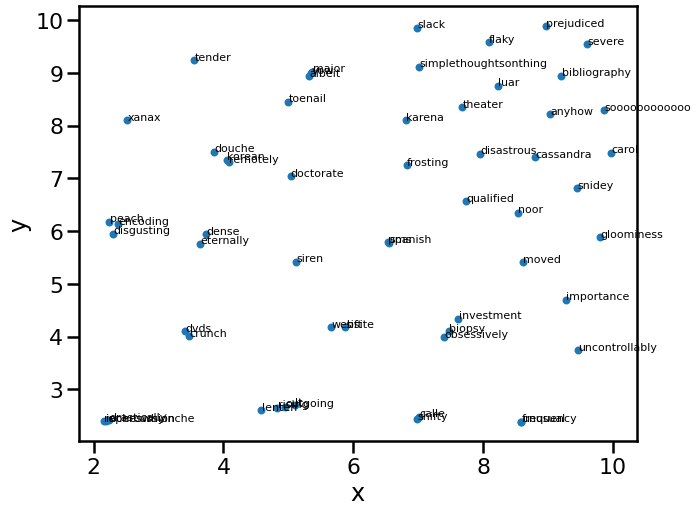

In [23]:
plot_region(x_bounds=(2,10), y_bounds=(2, 10))

In [24]:
glove_gensim.most_similar("blue")

[('red', 0.8435065150260925),
 ('black', 0.8065882921218872),
 ('pink', 0.786806046962738),
 ('green', 0.7868044376373291),
 ('purple', 0.7847141623497009),
 ('yellow', 0.7777267694473267),
 ('gray', 0.7732225060462952),
 ('bright', 0.743113100528717),
 ('white', 0.7365070581436157),
 ('dark', 0.717019259929657)]

## Create model

In [25]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.keras.layers import Dropout

In [26]:
EMBEDDING_DIM = 100
class_num = 6
model = Sequential()
model.add(Embedding(input_dim = num_words,
                    output_dim = EMBEDDING_DIM,
                    input_length= X_train_pad.shape[1],
                    weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.summary()

In [27]:
#EarlyStopping Stop training when a metric has stopped improving
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

## Train the model

In [28]:
history_embedding = model.fit(X_train_pad, y_train, 
                              epochs = 10, batch_size = 200, validation_data=(X_val_pad, y_val),
                              verbose = 1, callbacks = es)

Epoch 1/10
80/80 [==============================] - 541s 7s/step - loss: 1.4778 - accuracy: 0.4208 - val_loss: 1.2710 - val_accuracy: 0.5330
Epoch 2/10
80/80 [==============================] - 471s 6s/step - loss: 1.2179 - accuracy: 0.5434 - val_loss: 1.1180 - val_accuracy: 0.5930
Epoch 3/10
80/80 [==============================] - 464s 6s/step - loss: 0.9984 - accuracy: 0.6327 - val_loss: 0.7763 - val_accuracy: 0.7325
Epoch 4/10
80/80 [==============================] - 453s 6s/step - loss: 0.8029 - accuracy: 0.7089 - val_loss: 0.6268 - val_accuracy: 0.7760
Epoch 5/10
80/80 [==============================] - 437s 5s/step - loss: 0.6660 - accuracy: 0.7556 - val_loss: 0.4972 - val_accuracy: 0.8235
Epoch 6/10
80/80 [==============================] - 440s 6s/step - loss: 0.5642 - accuracy: 0.7937 - val_loss: 0.4261 - val_accuracy: 0.8495
Epoch 7/10
80/80 [==============================] - 524s 7s/step - loss: 0.4896 - accuracy: 0.8165 - val_loss: 0.3792 - val_accuracy: 0.8600
Epoch 8/10
80

## Vizualisation

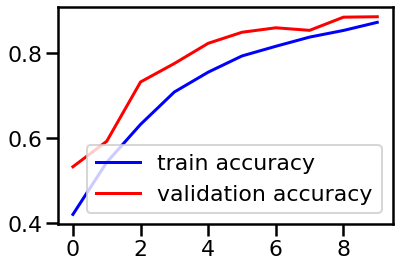

In [29]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

## Predict

In [30]:
y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)

In [31]:
from sklearn import metrics
print(metrics.classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       691
           1       0.87      0.85      0.86       281
           2       0.71      0.77      0.74       146
           3       0.91      0.93      0.92       568
           4       0.93      0.81      0.87       257
           5       0.62      0.72      0.67        57

    accuracy                           0.88      2000
   macro avg       0.82      0.83      0.83      2000
weighted avg       0.88      0.88      0.88      2000



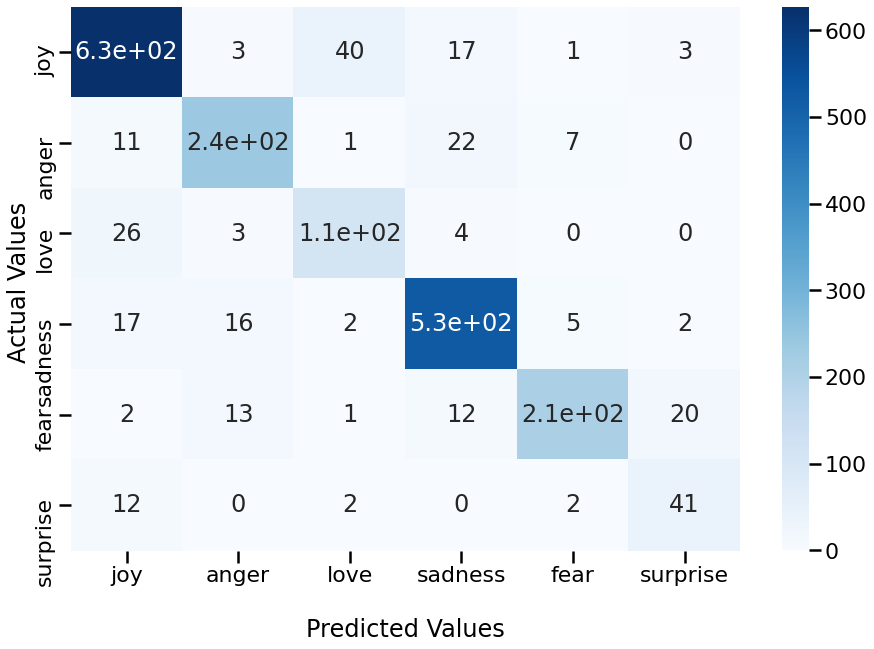

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_pred, y_true)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['joy','anger','love','sadness','fear','surprise'])
ax.yaxis.set_ticklabels(['joy','anger','love','sadness','fear','surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()